# Platt TPJ Dataset

## 1. Read in matlab files

Note: Data format after Matlab 2006a is stored as HDF5 now, thus scipy.io doesn't support the format of HDF5 anymore. We have to use h5py to decode the data.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid', {'axes.grid' : False})
%matplotlib inline

In [2]:
import h5py

# for Matlab datafile v7.3
datmat = h5py.File('data/spikes1.mat', 'r')['AllData']

In [3]:
list(datmat.keys())

['DayNum',
 'ImageNames',
 'ImageOn_ts',
 'Spikes_cell_num',
 'Spikes_ts',
 'cell_num',
 'is_first_image',
 'is_rewarded_image']

### Read data (can take a while)

In [4]:
imnames = []
for obj in datmat['ImageNames'][0]:
    imnames.append(''.join(chr(i) for i in datmat[obj].value))

In [5]:
daynum = []
for obj in datmat['DayNum'][0]:
    daynum.append(''.join(chr(i) for i in datmat[obj].value))

In [6]:
mapping = ({'ImageOn_ts': 'float', 
            'Spikes_cell_num': 'int', 
            'Spikes_ts': 'float',
            'cell_num': 'int',
            'is_first_image': 'int',
            'is_rewarded_image': 'int'
           })

In [7]:
vars = {}
for k, v in mapping.items():
    vars[k] = np.array(datmat[k])[0].astype(v)

### Make data frames

In [8]:
stims, codes = np.unique(imnames, return_inverse=True)

In [9]:
images = pd.DataFrame({'image': stims})
images.index.name = 'code'
images = images.reset_index()
print(images.shape)
images.head()

(1112, 2)


,code,image
0,0,lum_IMG_4142_trimmed.jpg
1,1,lum_IMG_4145_trimmed.jpg
2,2,lum_IMG_4146_trimmed.jpg
3,3,lum_IMG_4147_trimmed.jpg
4,4,lum_IMG_4148_trimmed.jpg


In [10]:
trials = pd.DataFrame({'date': daynum, 
                       'stim': codes,
                       'stim_on': vars['ImageOn_ts'],
                       'unit': vars['cell_num'],
                       'is_first': vars['is_first_image'],
                       'is_rewarded': vars['is_rewarded_image']
                      })
# trials = trials.sort_values(by=['unit', 'stim_on']).reset_index(drop=True)

In [11]:
print(trials.shape)
trials.head()

(690564, 6)


,date,is_first,is_rewarded,stim,stim_on,unit
0,2015_12_03,1,0,1050,13.445775,1001
1,2015_12_03,0,0,76,14.327300,1001
2,2015_12_03,0,1,173,14.991750,1001
3,2015_12_03,1,0,364,18.108650,1001
4,2015_12_03,0,0,438,18.991750,1001


In [12]:
spikes = pd.DataFrame({'unit': vars['Spikes_cell_num'], 'time': vars['Spikes_ts']})
# spikes = spikes.sort_values(by=['unit', 'time']).reset_index(drop=True)

In [13]:
print(spikes.shape)
spikes.head()

(3954792, 2)


,time,unit
0,0.374400,1001
1,0.588400,1001
2,0.599925,1001
3,1.039725,1001
4,1.045375,1001


**Note:** There's a nasty complexity here where, if the recording was stopped and restarted, the clock restarts as well, so that `stim_on` times *are not* guaranteed to increase monotonically.

**Solution**: Add `run` variable to handle clock reset.

In [14]:
grp = trials.groupby(['date', 'unit'])
chunks = []
for g, d in grp:
    times = d['stim_on']
    dt = times.diff()
    switches = times[dt < 0].index.tolist()
    dd = d.copy()
    if len(switches) > 0:
        dd['run'] = np.digitize(d.index, switches)
    else:
        dd['run'] = 0
    chunks.append(dd)
trials = pd.concat(chunks)

Do the same for spikes:

In [15]:
grp = spikes.groupby('unit')
chunks = []
for g, d in grp:
    times = d['time']
    dt = times.diff()
    switches = times[dt < 0].index.tolist()
    dd = d.copy()
    if len(switches) > 0:
        dd['run'] = np.digitize(d.index, switches)
    else:
        dd['run'] = 0
    chunks.append(dd)
spikes = pd.concat(chunks)

### Close file

In [16]:
datmat.file.close()

## 1.1. Examine Data

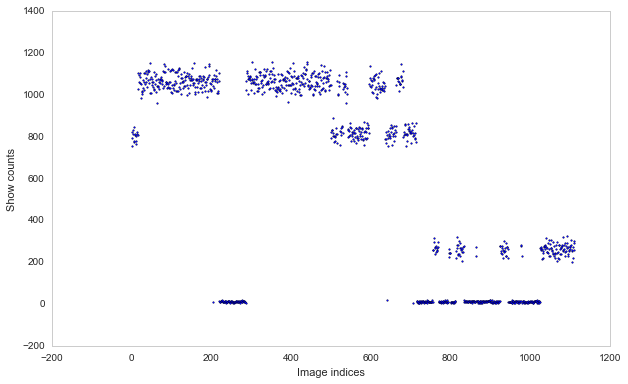

In [17]:
# The number of show times for each image
plt.figure(figsize=(10, 6))
plt.scatter(trials.groupby(by=['stim']).count().index, trials.groupby(by=['stim']).count()['stim_on'], s=3)
plt.xlabel('Image indices')
plt.ylabel('Show counts');

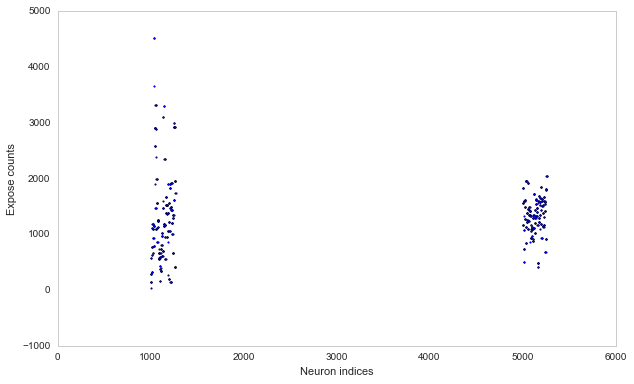

In [18]:
# Number of expose times for different neurons
plt.figure(figsize=(10, 6))
plt.scatter(trials.groupby(by=['unit']).count().index, trials.groupby(by=['unit']).count()['stim'], s=3)
plt.xlabel('Neuron indices')
plt.ylabel('Expose counts');

In [19]:
group = trials.groupby(by=['stim', 'unit']).count()['stim_on']
unstackgrp = group.unstack(level=0)

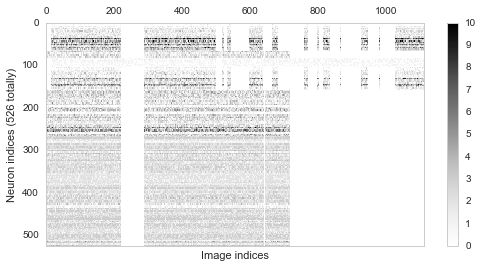

In [20]:
plt.figure(figsize=(20, 10))
plt.matshow(unstackgrp, aspect='auto', vmin=0, vmax=10)
plt.colorbar()
plt.xlabel('Image indices')
plt.ylabel('Neuron indices (526 totally)');

## 1.2. Add the column of spike counts

### Now take a look at the intervals between trials to determine the stim-on period

In [21]:
stimdiff = trials.stim_on.diff()[1:].values
np.min(stimdiff[stimdiff > 0])

0.44059999999999988

(0, 5)

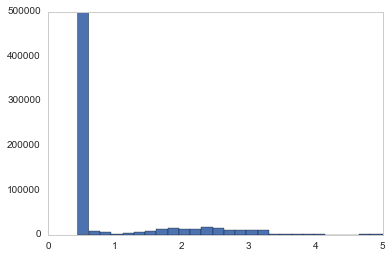

In [22]:
# histogram for same-day time intervals. Min: 0.44059999999999988, Max: 4294042.3105500005
plt.hist(stimdiff[(stimdiff > 0) & (stimdiff < 4e5)], bins=1000)
plt.xlim(0, 5)

### ... Finally decided to use a stim-on period of 400ms for all stimuli

*Amanda tells me 300ms is the minimum ISI. Use this as `Tpre`.*

Strategy: for each unit, make a histogram of spike counts in bins with edges at onset + Tpre, onset, and onset + Tpost. Evenly spaced subsets of these are then the 

In [23]:
tgrp = trials.groupby(['unit', 'run'])
sgrp = spikes.groupby(['unit', 'run'])
Tpre = -0.3
Tpost = 0.4  # epoch duration (in s)

chunks = []
for tg, sg in zip(tgrp, sgrp):
    tr, spk = tg[1].copy(), sg[1]
    onset = tr.stim_on.values
    bins = np.sort(np.concatenate([onset + Tpre, onset, onset + Tpost]))
    counts = np.histogram(spk.time, bins=bins)[0]  
    tr['baseline'] = counts[::3]  # ::3 bins are [stim_on + Tpre, stim_on)
    tr['count'] = counts[1::3]  # 1::3 bins are [stim_on, stim_on + Tpost)
    
    chunks.append(tr)
    
trials = pd.concat(chunks)

In [24]:
trials.head()

,date,is_first,is_rewarded,stim,stim_on,unit,run,baseline,count
0,2015_12_03,1,0,1050,13.445775,1001,0,0,5
1,2015_12_03,0,0,76,14.327300,1001,0,0,3
2,2015_12_03,0,1,173,14.991750,1001,0,0,0
3,2015_12_03,1,0,364,18.108650,1001,0,3,2
4,2015_12_03,0,0,438,18.991750,1001,0,0,12


In [25]:
# Take a look at the average spike counts
print("average counts: {}".format(np.mean(trials['count'])))
# plt.hist(trials['count'].values, bins = 100)
print("average counts is first: {}".format(np.mean(trials[trials['is_first'] == 1]['count'])))
print("average counts is rewarded: {}".format(np.mean(trials[trials['is_rewarded'] == 1]['count'])))

average counts: 1.097966300009847
average counts is first: 1.1375725366608134
average counts is rewarded: 1.1268992472131807


## 2. Determine which stimuli will be excluded from the dataset

In [26]:
stimcount = trials.groupby(by=['stim']).count()['stim_on']
dropidx = stimcount[stimcount < 100].index
# We found 314 stimuli that have been exposed to any neuron less than 100 times - most of them are 5~20 times.

In [27]:
dropidx

Int64Index([ 204,  220,  221,  222,  223,  224,  225,  226,  227,  228,
            ...
            1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024],
           dtype='int64', name='stim', length=314)

In [28]:
trials = trials[~trials['stim'].isin(dropidx)].reset_index(drop=True)

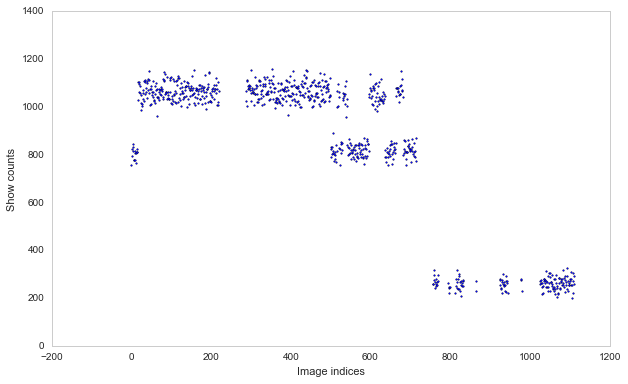

In [29]:
# The number of show times for each image
plt.figure(figsize=(10, 6))
plt.scatter(trials.groupby(by=['stim']).count().index, trials.groupby(by=['stim']).count()['stim_on'], s=3)
plt.xlabel('Image indices')
plt.ylabel('Show counts')

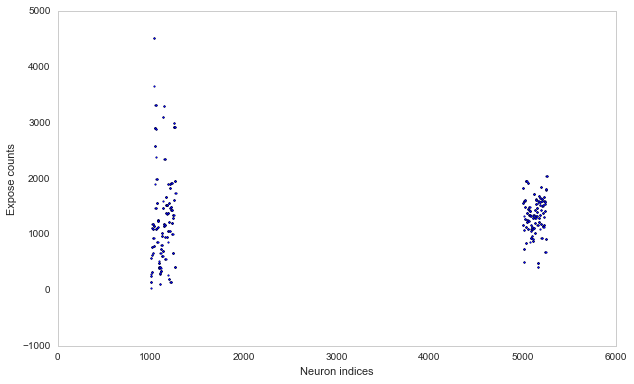

In [30]:
# Number of expose times for different neurons
plt.figure(figsize=(10, 6))
plt.scatter(trials.groupby(by=['unit']).count().index, trials.groupby(by=['unit']).count()['stim'], s=3)
plt.xlabel('Neuron indices')
plt.ylabel('Expose counts')

In [31]:
group = trials.groupby(by=['stim', 'unit']).count()['stim_on']
unstackgrp = group.unstack(level=0)

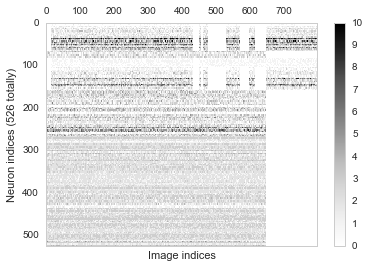

In [32]:
plt.matshow(unstackgrp, aspect='auto', vmin=0, vmax=10)
plt.colorbar()
plt.xlabel('Image indices')
plt.ylabel('Neuron indices (526 totally)');

## 3. Sort and output to .csv file

In [33]:
trials['time'] = np.unique(trials.stim, return_inverse=True)[1]
trials['trial'] = np.unique(trials.index, return_inverse=True)[1]

In [34]:
trials.head()

,date,is_first,is_rewarded,stim,stim_on,unit,run,baseline,count,time,trial
0,2015_12_03,1,0,1050,13.445775,1001,0,0,5,736,0
1,2015_12_03,0,0,76,14.327300,1001,0,0,3,76,1
2,2015_12_03,0,1,173,14.991750,1001,0,0,0,173,2
3,2015_12_03,1,0,364,18.108650,1001,0,3,2,296,3
4,2015_12_03,0,0,438,18.991750,1001,0,0,12,370,4


In [35]:
# only keep the columns that are useful to feed into model
trials = trials.drop(['date', 'stim_on'], 1).sort_values(by=['stim', 'unit'])
trials.to_csv('data/prepared_data.csv', index=False)

## 2. Read image categories

In [36]:
# Read image categories
iminfo = pd.read_table("data/stimulus_characteristics.txt")
iminfo = iminfo.rename(columns={'image_file_name': 'image'}).merge(images)

In [37]:
iminfo.head()

,image,monkey_name,Human?,Monkey face?,Object?,Perinea?,direct gaze?,averted gaze?,face oriented L,face oriented R,...,Female Perinea?,Cayo,Colony,head visible,tail visible,num legs,side view,frontal view,partially occuded,code
0,lum_affil001.jpg,NaN,0,1,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,16
1,lum_affil004.jpg,NaN,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,17
2,lum_affil005.jpg,NaN,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,18
3,lum_apple.jpg,NaN,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
4,lum_averted001.jpg,NaN,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,20


In [38]:
# exclude the images that were not presented in trials
# imnames is a list of image names presented in trials
iminfo = iminfo[(iminfo.image.isin(imnames))]
iminfo = iminfo.sort_values(by=['image']).reset_index(drop=True)

In [39]:
# Large categories are 'human' (342), 'monkey face' (396), 'object' (224), 'perinea' (150)
catsum = iminfo.sum(axis=0)
catsum

Human?                  342
Monkey face?            396
Object?                 224
Perinea?                150
direct gaze?            104
averted gaze?           262
face oriented L         132
face oriented R         112
face straight           122
threat?                   8
scrambled?              557
Male Perinea?            32
Female Perinea?         118
Cayo                    176
Colony                  220
head visible             12
tail visible             63
num legs                147
side view                21
frontal view             54
partially occuded        30
code                 617716
dtype: int64

In [40]:
iminfo.index.isin(trials.stim).sum()

798

In [41]:
iminfo798 = iminfo[iminfo.index.isin(trials.stim)]

In [42]:
iminfo.shape, iminfo798.shape

((1112, 24), (798, 24))

In [44]:
iminfo798.head()

,image,monkey_name,Human?,Monkey face?,Object?,Perinea?,direct gaze?,averted gaze?,face oriented L,face oriented R,...,Female Perinea?,Cayo,Colony,head visible,tail visible,num legs,side view,frontal view,partially occuded,code
0,lum_IMG_4142_trimmed.jpg,NaN,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
1,lum_IMG_4145_trimmed.jpg,NaN,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
2,lum_IMG_4146_trimmed.jpg,NaN,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,1,0,0,2
3,lum_IMG_4147_trimmed.jpg,NaN,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,1,0,3
4,lum_IMG_4148_trimmed.jpg,NaN,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,1,0,4


In [45]:
iminfo798.to_csv('data/iminfo798.csv', index=False)